In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.io.fits as fits

import pysm3
import pysm3.units as u

import healpy as hp

from fgbuster import (CMB, Dust, Synchrotron,xForecast,
                      basic_comp_sep,get_sky,
                      get_observation, get_instrument,get_noise_realization)
from fgbuster.visualization import corner_norm

from functools import partial
from scipy.interpolate import griddata
from skimage.restoration import inpaint

import pymaster as nmt

import sys
sys.path.append('/home/rguidetti')
from PolAngle import *
from beam import * 
from map import *
from convolution import * 
from beam_class import *
from PatchFunctions import *  # nuove funzioni in quanto quelle vecchie lavoravano con mappe NxN. Queste funzionano per mappe rettangolari Nx,Ny

# Inizializzazione mappa

In [2]:
nside = 64

sky = get_sky(nside, 'd0s0')
instrument = get_instrument('LiteBIRD')
freq_maps = get_observation(instrument, sky)


pix_area_deg = hp.pixelfunc.nside2pixarea(nside, degrees=True) # degrees
pix_size_deg = np.sqrt(pix_area_deg) # degrees
pix_size = pix_size_deg *60 #arcmin
pix_size

print(f"With nside = {nside}, the pixel size is {pix_size} arcmin ({pix_size_deg} degrees)")


########################################################################################################

# seleziono solo alcune frequenze per comodità (8 su 15) 

mappa40  = freq_maps[0, :, :]
mappa60  = freq_maps[2, :, :]
mappa78  = freq_maps[4, :, :]
mappa100 = freq_maps[6, :, :]
mappa140 = freq_maps[8, :, :]
mappa195 = freq_maps[10, :, :]
mappa280 = freq_maps[12, :, :]
mappa402 = freq_maps[14, :, :]


##############################################################

I40 = mappa40[0,:]
Q40 = mappa40[1,:]
U40 = mappa40[2,:]

I60 = mappa60[0,:]
Q60 = mappa60[1,:]
U60 = mappa60[2,:]

I78 = mappa78[0,:]
Q78 = mappa78[1,:]
U78 = mappa78[2,:]

I100 = mappa100[0,:]
Q100 = mappa100[1,:]
U100 = mappa100[2,:]

I140 = mappa140[0,:]
Q140 = mappa140[1,:]
U140 = mappa140[2,:]

I195 = mappa195[0,:]
Q195 = mappa195[1,:]
U195 = mappa195[2,:]

I280 = mappa280[0,:]
Q280 = mappa280[1,:]
U280 = mappa280[2,:]

I402 = mappa402[0,:]
Q402 = mappa402[1,:]
U402 = mappa402[2,:]

np.shape(I40)

With nside = 64, the pixel size is 54.96778258907849 arcmin (0.9161297098179748 degrees)


(49152,)

# Creazione patch
Creazione patch e conversione 1D -> 2D

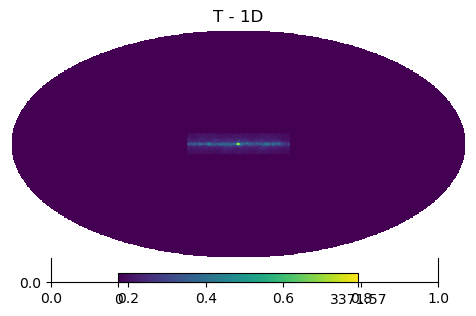

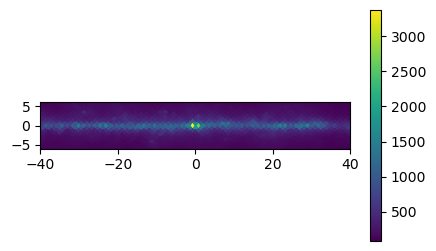

In [3]:
# patch
#RA1 = -60 
#RA2 = 60
#dec1 = -70
#dec2 = -40

#RA1 = -110 
#RA2 = 80
#dec1 = -20
#dec2 = 30

RA1 = -40 
RA2 = 40
dec1 = -6
dec2 = 6

idxs, resol = create_rectangular_patch([RA1, RA2], [dec1, dec2], nside)


map_array= [I40, Q40, U40, 
            I60, Q60, U60, 
            I78, Q78, U78, 
            I100, Q100, U100, 
            I140, Q140, U140, 
            I195, Q195, U195, 
            I280, Q280, U280, 
            I402, Q402, U402 ]


for map in map_array:

    visualize_patch = map.copy()

    mask = np.zeros_like(visualize_patch, dtype=bool)
    mask[idxs] = True

    #visualize_patch[~mask] = hp.UNSEEN

    map[~mask] = 0.0
    
########################################################################################

maps_2d = {}
extent=(RA1, RA2, dec1, dec2)

bands = ['40', '60', '78', '100', '140', '195', '280', '402']
types = ['I', 'Q', 'U']



for band in bands:
    for map_type in types:
        map_name = f"{map_type}{band}" 
        
        
        map_data = globals()[map_name]
        
        mp_hp, ra_hp, dec_hp = convert2grid(map_data, nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
        

        variable_prefix = f"{map_type}{band}"
        maps_2d[f"mp_hp_{variable_prefix}"] = mp_hp 
        maps_2d[f"ra_hp_{variable_prefix}"] = ra_hp
        maps_2d[f"dec_hp_{variable_prefix}"] = dec_hp

#####################################################################################################
fig, ax = plt.subplots(figsize=(5, 3))
hp.mollview(I40, title='T - 1D', fig=fig.number)


plt.figure(figsize=(5, 3))
plt.imshow(maps_2d['mp_hp_I40'],origin='lower', extent=extent)
plt.colorbar()

### Inizializzazione variabili mappe

In [4]:
Ny, Nx = np.shape(maps_2d['mp_hp_I40']) 
print(Nx, Ny)

X_width = Nx * pix_size/60
Y_width = Ny * pix_size/60

# color map
c_min, c_max     = -10, 10  


import random


frequencies = [40, 60, 78, 100, 140, 195, 280, 402]

I_maps = {
    40: maps_2d['mp_hp_I40'], 60: maps_2d['mp_hp_I60'], 78: maps_2d['mp_hp_I78'],
    100: maps_2d['mp_hp_I100'], 140: maps_2d['mp_hp_I140'], 195: maps_2d['mp_hp_I195'],
    280: maps_2d['mp_hp_I280'], 402: maps_2d['mp_hp_I402']}


Q_maps = {
    40: maps_2d['mp_hp_Q40'], 60: maps_2d['mp_hp_Q60'], 78: maps_2d['mp_hp_Q78'],
    100: maps_2d['mp_hp_Q100'], 140: maps_2d['mp_hp_Q140'], 195: maps_2d['mp_hp_Q195'],
    280: maps_2d['mp_hp_Q280'], 402: maps_2d['mp_hp_Q402']}

U_maps = {
    40: maps_2d['mp_hp_U40'], 60: maps_2d['mp_hp_U60'], 78: maps_2d['mp_hp_U78'],
    100: maps_2d['mp_hp_U100'], 140: maps_2d['mp_hp_U140'], 195: maps_2d['mp_hp_U195'],
    280: maps_2d['mp_hp_U280'], 402: maps_2d['mp_hp_U402']}


262 40


# Beam - MC
Voglio fare varie simulazioni adcon diversi valori dei picchi


In [5]:
num_beam = 3        


array_dB = np.zeros((num_beam, 4))


for i in range(num_beam):
    start_values = [random.uniform(-50, -20) for _ in range(4)]
    
    peak_error = [random.uniform(-5, -0.1) for _ in range(4)]
    sign = np.random.choice([-1, 1], size = 4)
    
    array_dB[i]  = (start_values + sign * peak_error)
        
    print("Peaks = ", np.sort(array_dB[i])[::-1])

    array_dB[i]  = np.sort(array_dB[i])[::-1]
    

# VARIABLES
FWHM_x = 4.5  # degrees
FWHM_y = 5.5  # degrees

    
ellipticity = (FWHM_x - FWHM_y) / (FWHM_x + FWHM_y)
print("ellipticity = ", ellipticity)


r1 = np.array([10000, 20000,40000, 60000]) #angular distance of the peaks
r = 20 # width of the rings

theta = 0 # angle of rotation of the beam
a = 1 # major axis of ellipses 


Peaks =  [-19.05969654 -28.20272191 -36.68653478 -43.98089144]
Peaks =  [-16.12190154 -25.97745488 -27.61724949 -36.68462687]
Peaks =  [-32.10681988 -33.51198211 -33.71778749 -45.78607728]
ellipticity =  -0.1


In [6]:
##########################################################################################################

# COORDINATES LIKE THE ONES OF THE MAPS

Nx = int(Nx)
Ny = int(Ny)

onesx = np.ones(Nx)
onesy = np.ones(Ny)

indsx = (np.arange(Nx)+.5 - Nx/2.) * pix_size
indsy = (np.arange(Ny)+.5 - Ny/2.) * pix_size

X = np.outer(onesy, indsx)
Y = np.outer(indsy, onesx)
R = np.sqrt(X**2. + Y**2.)


#########################################################################################

# BEAM

beam_x = {}
beam_x_perf = {}

for i in range(num_beam):
        beam_x_perf[i], _, _,_, beam_x[i], _ = create_beam_secpeaks(pix_size, FWHM_x, FWHM_y, theta, array_dB[i], r, r1, X, Y, a, ellipticity)
        

######################################################################################################


### beam systematics dictionary
bs = {"budy":{"A":3e-10,"FWHP":100,"R":1100.,"psi":0.3,"polfracQ":0.5,"polfracU":0.01},  
                                                                         # little budy amplitude, 
                                                                         #FWHP, offset spacing, rotationa angle (radians)
                                                                        # pol_fraction for Q and U
     "ghostshelf": {"A":1e-10,"Diam":40.,"roll_off":7.},    #model of ghosting, amplitude (A), diameter (Diam) 
     "hex_crostalk":{"grid_space": 30.,"N":10,"neighbor_exp_fall":0.05}, 
                                                                               ## model of optical cross talk 
                                                                               ## to detectors on a hex grid
                                                                               ## assumed to be exponetial
                                                                               ## assumed to be 50% polarized
      "TtoQ":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
      "TtoU":{"mono":1e-3,"dip_x":1e-2,"dip_y":1e-2,"quad_x":1e-2,"quad_45":1e-2},
                                                                  ## multiplole expansion leakage
      'psi':0.01*np.pi/180.
                                  ## detetor angle rotations
                   }

beam_sys = BeamSystematics()

beam_TT = {}
beam_QQ = {}
beam_UU = {}

for i in range(num_beam):
    beam_TT[i], beam_QQ[i], beam_UU[i], _, _, _, _ = make_systematics_beams_r(Nx, Ny, pix_size, FWHM_x, beam_x[i], bs)
   


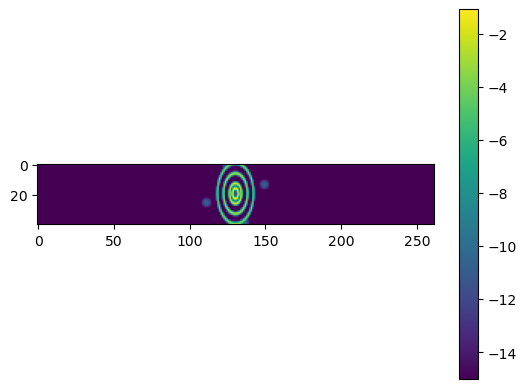

In [7]:
plt.imshow(np.log10(beam_TT[0]+1e-15))
plt.colorbar()
#plt.xlim(150, 250)
#plt.ylim(20,80)

In [8]:
# convolution with r[eal beam
Q_conv_real_all = {}
U_conv_real_all = {}
I_conv_real_all = {}
    
for freq in frequencies:
    Q_map = Q_maps[freq]
    U_map = U_maps[freq]
    I_map = I_maps[freq]

    I_conv_real  = np.zeros((num_beam, *I_map.shape))
    Q_conv_real  = np.zeros((num_beam, *Q_map.shape))
    U_conv_real  = np.zeros((num_beam, *U_map.shape))

    
    for i in range(num_beam):
        I_conv_real[i, :, :] = convolve_map_with_beam(I_map, beam_TT[i])
        Q_conv_real[i, :, :] = convolve_map_with_beam(Q_map, beam_QQ[i])
        U_conv_real[i, :, :] = convolve_map_with_beam(U_map, beam_UU[i])
        
    I_conv_real_all[freq] = I_conv_real
    Q_conv_real_all[freq] = Q_conv_real
    U_conv_real_all[freq] = U_conv_real

# APODIZZAZIONE

In [9]:
window = (cosine_window_r(Nx, Ny, x_range=[-np.pi /4, np.pi /4], y_range=[-np.pi /4, np.pi /4]))

for freq in frequencies:
    Q_conv_real_all[freq] *= window
    U_conv_real_all[freq] *= window


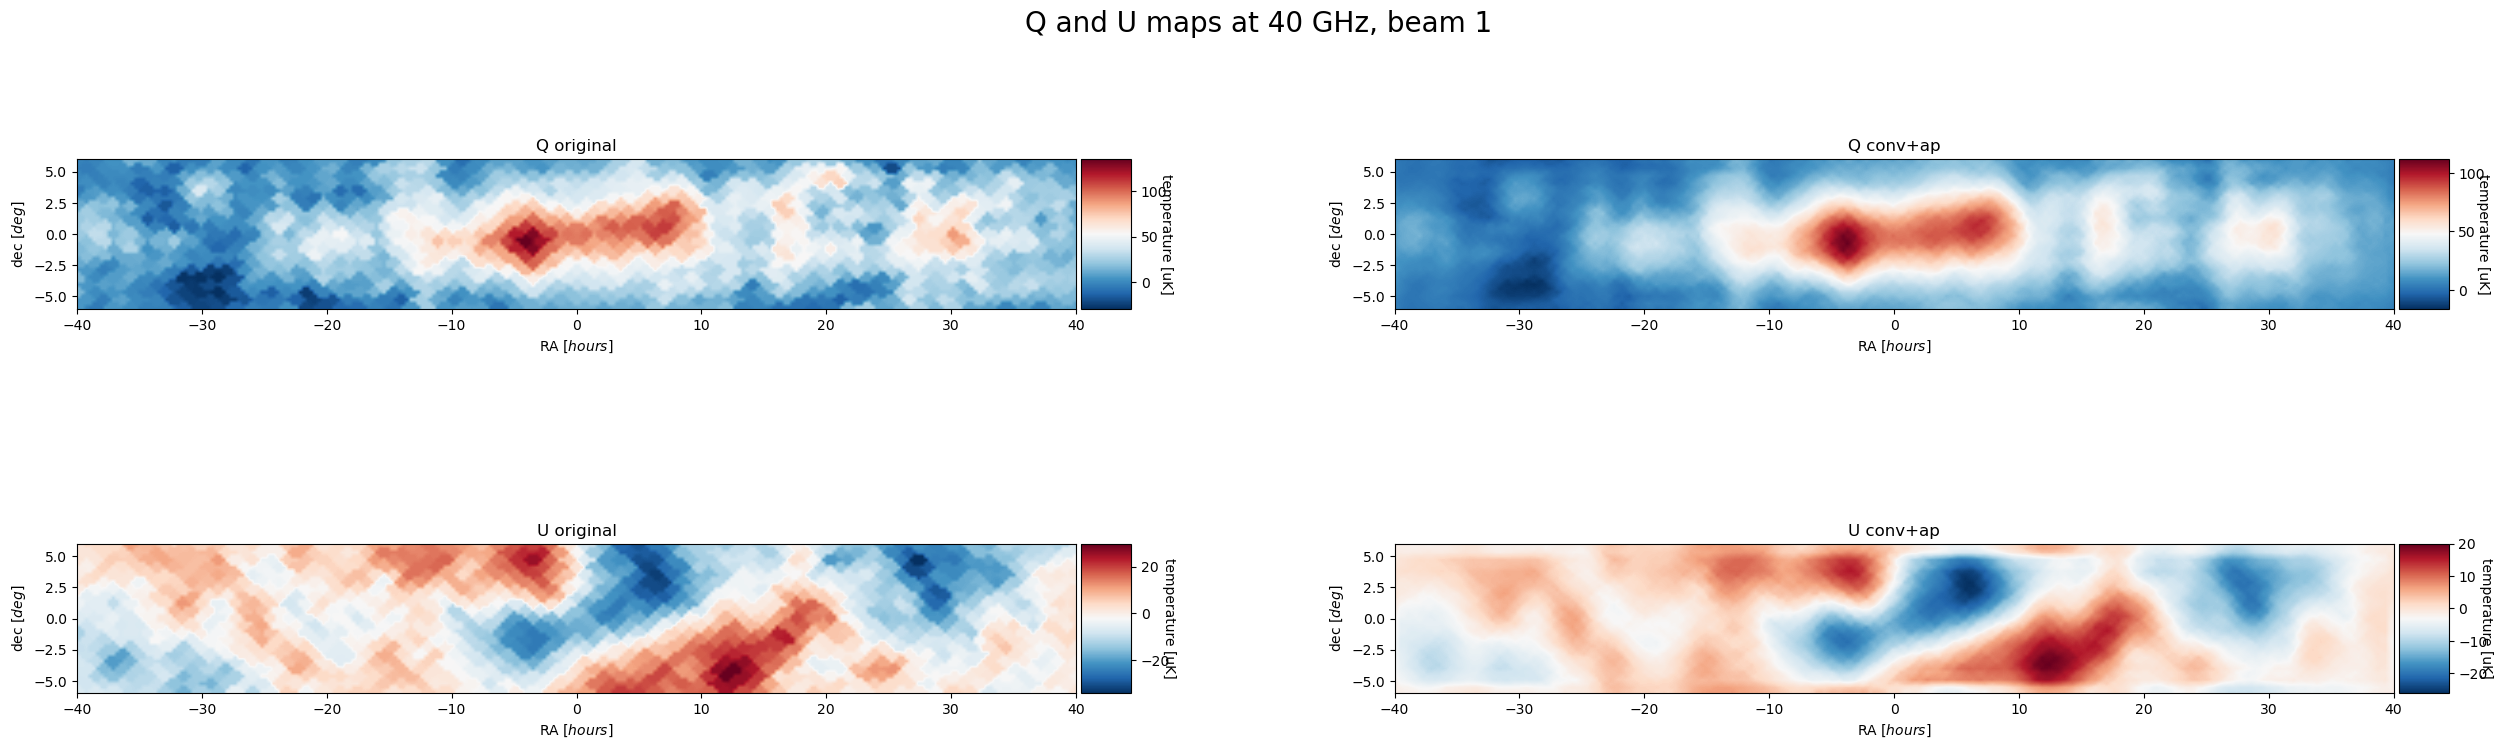

In [10]:
# plot - 1 frequenza (40) per un angolo (1°) per una simulazione (1°)
Map_to_Plot = [maps_2d['mp_hp_Q40'], Q_conv_real_all[40][0], maps_2d['mp_hp_U40'], U_conv_real_all[40][0]]
title = ["Q original", "Q conv+ap", "U original", "U conv+ap"]
c_factor_max = [np.max(Map_to_Plot[0]), np.max(Map_to_Plot[1]), np.max(Map_to_Plot[2]), np.max(Map_to_Plot[3])]
c_factor_min = [np.min(Map_to_Plot[0]), np.min(Map_to_Plot[1]), np.min(Map_to_Plot[2]), np.min(Map_to_Plot[3])]

tipo = 'coords'
fig, axs = plt.subplots(2, 2, figsize=(25, 8))
axs      = axs.flatten()
for i, (map_data, c_factor_iter_min, c_factor_iter_max) in enumerate(zip(Map_to_Plot, c_factor_min, c_factor_max)):
        Plot_CMB_Map_compact(axs[i], map_data, c_factor_iter_min, c_factor_iter_max, X_width, Y_width, extent, tipo)
        axs[i].set_title(title[i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.2, top=0.90)
plt.suptitle(f'Q and U maps at {frequencies[0]} GHz, beam {1}', fontsize=20)
#plt.savefig('/Users/guide/Documents/University/TESI/immagini/FullModelPerturbation.png')
plt.show()


# COMPONENT SEPARATION
Trasformo in 1D, unisco le 8 frequenza per ogni simulazione, component separation

In [11]:
idx = hp.ang2pix(nside, -ra_hp, dec_hp, lonlat=True)

# Dizionari per memorizzare le mappe piatte
Q_flat_all = {}
U_flat_all = {}
I_flat_all = {}

for freq in frequencies:
    Q_map_conv = Q_conv_real_all[freq]
    U_map_conv = U_conv_real_all[freq]

    num_angles, height, width = Q_map_conv.shape #num_sim_per_angle

    Q_map_flat = np.zeros((num_beam, *I40.shape)) #num_sim_per_angle
    U_map_flat = np.zeros((num_beam, *I40.shape))

    for i in range(num_beam):
        #for j in range(num_sim_per_angle):
        new_map_Q = np.zeros_like(I40)
        new_map_Q[idx] = Q_map_conv[i].flatten()
        Q_map_flat[i] = new_map_Q

        new_map_U = np.zeros_like(I40)
        new_map_U[idx] = U_map_conv[i].flatten()
        U_map_flat[i] = new_map_U

    Q_flat_all[freq] = Q_map_flat
    U_flat_all[freq] = U_map_flat

In [12]:
full_array = np.zeros((len(frequencies), 2, num_angles, *I40.shape)) #num_sim_per_angle

for f_idx, freq in enumerate(frequencies):
    Q_stack = Q_flat_all[freq]
    U_stack = U_flat_all[freq]

    freq_stack = np.stack([Q_stack, U_stack], axis=0)

    full_array[f_idx] = freq_stack
    
print(full_array.shape)  # Expected shape: (8, 2, 3, 49152)

full_array = full_array.transpose(2, 0, 1, 3)
print(full_array.shape)  # Expected shape: (3, 8, 2, 49152)

(8, 2, 3, 49152)
(3, 8, 2, 49152)


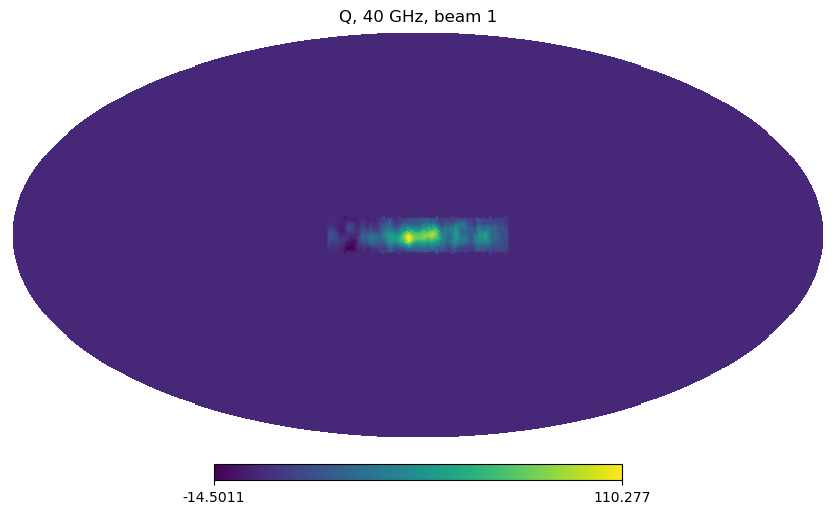

In [13]:
# mappa Q, 40 GHz,  angolo 1
hp.mollview(full_array[0][0][0], title=f'Q, 40 GHz, beam 1')

In [14]:
instrument = get_instrument('LiteBIRD')

df   = pd.DataFrame(instrument)
instrument_freq = df.iloc[[0, 2, 4, 6, 8, 10, 12, 14], :]   #estraggo le frequenze che ho selezionato creando le patch


In [15]:
components = [CMB(), Dust(350.), Synchrotron(20.)]
results = []
cmb_Q = {}
cmb_U = {}
cmb_I = {}

for i in range(num_beam):  
    #for j in range(num_sim_per_angle):

        result = basic_comp_sep(components, instrument_freq, full_array[i]) #sim_idx


        results.append(result)

        print(f"Simulation {i+1} - beam {i+1}")
        print(result.x)
        print('\n')

    
        if i not in cmb_Q:
            cmb_Q[i] = {}
            cmb_U[i] = {}
            cmb_I[i] = {}

        cmb_Q[i] = result.s[0, 0] #[j]
        cmb_U[i] = result.s[0, 1] #[j]

Simulation 1 - beam 1
[ 1.53999991 20.         -3.        ]


Simulation 2 - beam 2
[ 1.5399999  19.99999998 -2.99999985]


Simulation 3 - beam 3
[ 1.53999991 20.         -3.        ]




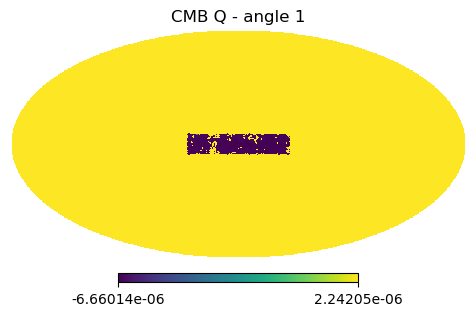

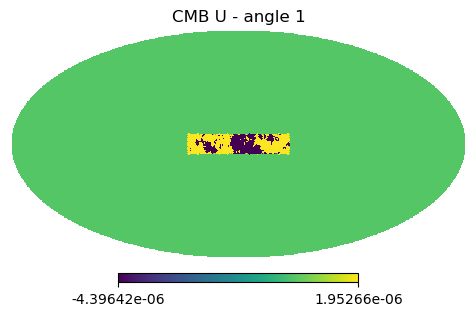

In [16]:
plt.figure(figsize=(5, 3))
hp.mollview(cmb_Q[0], title='CMB Q - angle 1', norm='hist', fig=fig.number)
plt.show()

plt.figure(figsize=(5, 3))
hp.mollview(cmb_U[0], title='CMB U - angle 1', norm='hist', fig=fig.number)
plt.show()

# DECONVOLUTION
Torno in 2D, deconvolvo

In [17]:
cmb_Q_2d = {}
cmb_U_2d = {}
cmb_I_2d = {}

def safe_convert2grid(data, nside, resol, ra_range, dec_range, method, fill_nan):
    if data.size == 0:
        raise ValueError("Input data is empty.")
    
    reproj_map, ra_hp, dec_hp = convert2grid(data, nside, resol, ra_range, dec_range, method, fill_nan)
    
    if np.isnan(reproj_map).all():
        raise ValueError("Reprojected map is all NaNs.")
    
    return reproj_map, ra_hp, dec_hp

for i in range(num_beam):
    #cmb_Q_2d[i] = {}
    #cmb_U_2d[i] = {}
    #cmb_I_2d[i] = {}
    
    #for j in range(num_sim_per_angle):
    
    cmb_Q_2d[i], ra_hp, dec_hp = safe_convert2grid(cmb_Q[i], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True)
    cmb_U_2d[i], ra_hp, dec_hp = safe_convert2grid(cmb_U[i], nside, resol/3, [RA1, RA2], [dec1, dec2], method='healpy', fill_nan=True) 


In [18]:
# perfect beam 
perf_beam = {}
for i in range(num_beam):
    perf_beam[i], _ = create_perf_beam(pix_size, FWHM_x, FWHM_y, X, Y, theta)
     

Q_deconv = {}
U_deconv = {}
I_deconv = {}


for i in range(num_beam):
    #Q_deconv[i] = {}
    #U_deconv[i] = {}
    #I_deconv[i] = {}
    
    #for j in range(num_sim_per_angle):

    Q_deconv[i] =  deconvolve_map(cmb_Q_2d[i], beam_x[i], perf_beam[i]) #cmb_Q_2d[i][j]
    U_deconv[i] =  deconvolve_map(cmb_U_2d[i], beam_x[i], perf_beam[i]) #cmb_U_2d[i][j]
    

# POWER SPECTRA 
Con Namaster

In [19]:
pix_size_rad = np.radians(pix_size /60)

X_width_rad = Nx * pix_size_rad
Y_width_rad = Ny * pix_size_rad


# Masks:
mask = np.ones_like(Q_deconv[0])

# bins


l0_bins = np.arange(Nx/8) * 8 * np.pi/X_width_rad
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/X_width_rad


b = nmt.NmtBinFlat(l0_bins, lf_bins)

# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()        
        
BB_PS= {}
EE_PS= {}        
        
from tqdm import tqdm
for i in tqdm(range(num_beam)):
    #TT_PS[i] = {}
    #BB_PS[i] = {}
    #EE_PS[i] = {}
    #for j in range (num_sim_per_angle):
        
        #I = I_deconv[i][j]
    Q = Q_deconv[i]
    U = U_deconv[i]
        
    f2 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [Q, U], purify_b=True)
        #f0 = nmt.NmtFieldFlat(X_width_rad, Y_width_rad, mask, [I])
        
        #w00 = nmt.NmtWorkspaceFlat()
        #w00.compute_coupling_matrix(f0, f0, b)
        #w02 = nmt.NmtWorkspaceFlat()
        #w02.compute_coupling_matrix(f0, f2, b)
    w22 = nmt.NmtWorkspaceFlat()
    w22.compute_coupling_matrix(f2, f2, b)
   
        #cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
    
        #cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
        #cl00_uncoupled = w00.decouple_cell(cl00_coupled)
        #cl02_coupled = nmt.compute_coupled_cell_flat(f0, f2, b)
        #cl02_uncoupled = w02.decouple_cell(cl02_coupled)
    cl22_coupled = nmt.compute_coupled_cell_flat(f2, f2, b)
    cl22_uncoupled = w22.decouple_cell(cl22_coupled)

        #TT_PS[i][j] = cl00_uncoupled[0]
        #EE_PS[i][j] = cl22_uncoupled[0]
        #BB_PS[i][j] = cl22_uncoupled[3]
    EE_PS[i] = cl22_coupled[0]
    BB_PS[i] = cl22_coupled[3]

100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


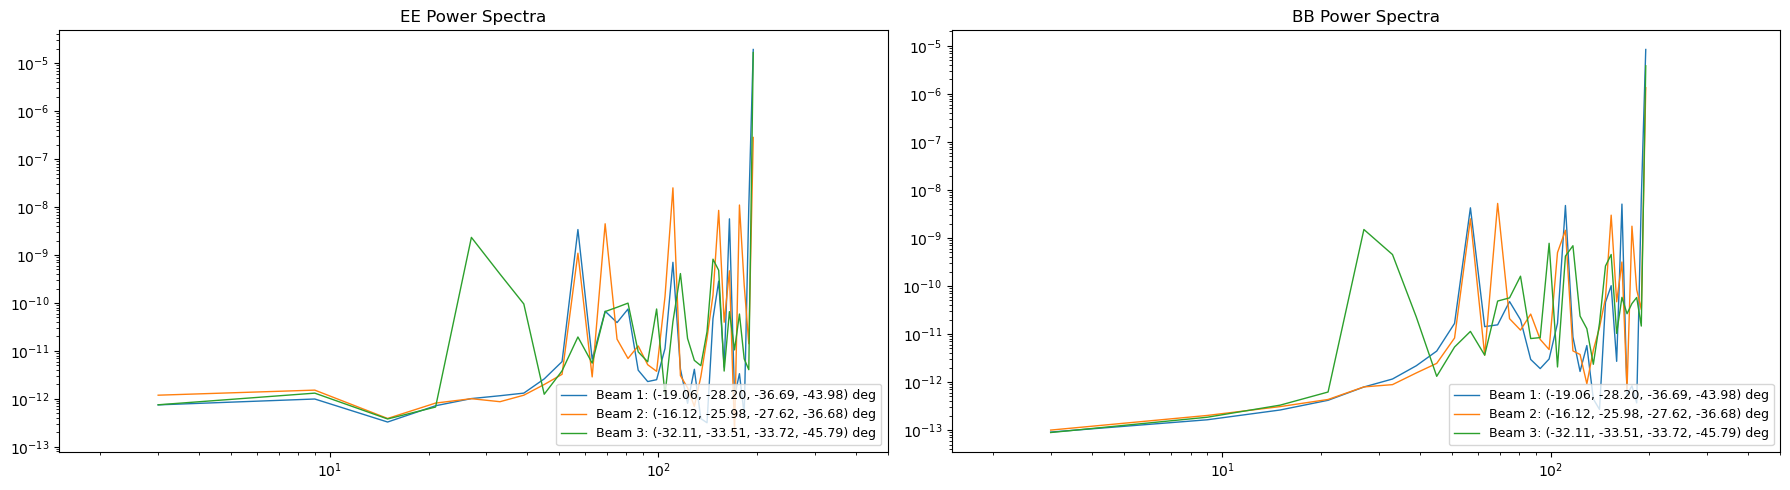

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5))
factor = ells_uncoupled * (ells_uncoupled + 1) / (2 * np.pi)

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

for i in range(num_beam):
    
    # Plot EE power spectra
    ax[0].set_title(f'EE Power Spectra', fontsize=12)
    
    #for j in range(num_sim_per_angle):
    color = colors[i % len(colors)]
    ax[0].plot(ells_uncoupled, EE_PS[i] * factor, color=color, linewidth=1, label=f'Beam {i+1}: ({", ".join([f"{x:.2f}" for x in array_dB[i]])}) deg')
    
    ax[0].loglog()
    ax[0].legend(fontsize=9,loc="lower right")
    ax[0].set_xlim(1.5, 500)

    # Plot BB power spectra
    ax[1].set_title(f'BB Power Spectra', fontsize=12)
    #for j in range(num_sim_per_angle):
    color = colors[i % len(colors)]
    ax[1].plot(ells_uncoupled, BB_PS[i] * factor, color=color, linewidth=1, label=f'Beam {i+1}: ({", ".join([f"{x:.2f}" for x in array_dB[i]])}) deg')
    
    ax[1].loglog()
    ax[1].legend(fontsize=9, loc="lower right")
    ax[1].set_xlim(1.5, 500)

plt.tight_layout()

plt.show()

# r FORECAST
Ho cambiato la funzione in modo che non stampi niente

In [21]:
def cosmological_likelihood(Cls_, fsky, r_input, fisher):
    import bisect
    from fgbuster.cosmology import _get_Cl_cmb
    """
    This function returns the c.l. from
    the likelihood on r provided Cls
    :param Cls_: Cls^stat from comp sep
            note: they must start from l=2
    :param fsky: percentage of the sky to use
    :param r_input: assumed value of r
    :param fisher: return 68% confidence level on r or sigma(r) from fisher
    :return sigma_r: 68% confidence level on r or sigma from fisher
    """
    lmax = len(Cls_)
    ell = np.arange(2, lmax + 2)

    # values of r over which the likelihood is computed
    if r_input >= 0.005:
        r_max = 2*r_input
    else:
        r_max = 0.01
    r_v = np.linspace(0.000, r_max, num=10 ** 6)
    r_v = r_v.tolist()
    # add r_input in r_v
    if r_input not in r_v:
        bisect.insort(r_v, r_input)
    r_v = np.array(r_v)

    ClBBr1 = _get_Cl_cmb(0.0, 1.0)[2][2:lmax + 2]
    ClBBlens = _get_Cl_cmb(1.0, 0.0)[2][2:lmax + 2]
    Data = ClBBlens + Cls_ + _get_Cl_cmb(0.0, r_input)[2][2:lmax+2]

    if fisher:
        # computing sigma(r=r_input) from fisher
        F = np.sum((2 * ell + 1) * fsky / 2 * ClBBr1 ** 2 / Data ** 2)
        sigma_r_fisher = np.sqrt(1.0 / F)

        return sigma_r_fisher

    else:
        # gridding the likelihood
        logL = np.array([np.sum((2 * ell + 1) / 2 * fsky * (np.log(ClBBr1 * r_ + ClBBlens + Cls_)
                                                                + Data / (ClBBr1 * r_ + ClBBlens + Cls_))) for r_ in r_v])
        L = np.exp(-(logL - np.min(logL)))
        # computing sigma(r=r_input) as the 68% confidence level on r
        rs_pos = r_v[r_v > r_input]
        plike_pos = L[r_v > r_input]
        cum = np.cumsum(plike_pos)
        cum /= cum[-1]
        sigma_r = rs_pos[np.argmin(np.abs(cum - 0.68))]

    return sigma_r

In [22]:
def xForecast(components, instrument, d_fgs, lmin, lmax,
              Alens=1.0, r=0.001, make_figure=False,
              **minimize_kwargs):
    from fgbuster import  CMB, Dust, Synchrotron, algebra, mixingmatrix, observation_helpers
    import os.path as op
    import numpy as np
    import pylab as pl
    import healpy as hp
    import scipy as sp
    from fgbuster.algebra import comp_sep, W_dBdB, W_dB, W, _mmm, _utmv, _mmv
    from fgbuster.mixingmatrix import MixingMatrix
    from fgbuster.observation_helpers import standardize_instrument
    from fgbuster.cosmology import _get_Cl_noise,_get_Cl_cmb
    import inspect
    from time import time
    import six
    import numpy as np
    import scipy as sp
    import numdifftools
    from functools import reduce
   
    
    # Preliminaries
    instrument = standardize_instrument(instrument)
    nside = hp.npix2nside(d_fgs.shape[-1])
    n_stokes = d_fgs.shape[1]
    n_freqs = d_fgs.shape[0]
    invN = np.diag(hp.nside2resol(nside, arcmin=True) / (instrument.depth_p))**2
    mask = d_fgs[0, 0, :] != 0.
    fsky = mask.astype(float).sum() / mask.size
    ell = np.arange(lmin, lmax+1)
    #print('fsky = ', fsky)

    ############################################################################
    # 1. Component separation using the noise-free foregrounds templare
    # grab the max-L spectra parameters with the associated error bars
    #print('======= ESTIMATION OF SPECTRAL PARAMETERS =======')
    A = MixingMatrix(*components)
    A_ev = A.evaluator(instrument.frequency)
    A_dB_ev = A.diff_evaluator(instrument.frequency)

    x0 = np.array([x for c in components for x in c.defaults])
    if n_stokes == 3:  # if T and P were provided, extract P
        d_comp_sep = d_fgs[:, 1:, :]
    else:
        d_comp_sep = d_fgs

    res = comp_sep(A_ev, d_comp_sep.T, invN, A_dB_ev, A.comp_of_dB, x0,
                   **minimize_kwargs)

    res.params = A.params
    res.s = res.s.T
    A_maxL = A_ev(res.x)
    A_dB_maxL = A_dB_ev(res.x)
    A_dBdB_maxL = A.diff_diff_evaluator(instrument.frequency)(res.x)

    #print('res.x = ', res.x)

    ############################################################################
    # 2. Estimate noise after component separation
    ### A^T N_ell^-1 A
    #print('======= ESTIMATION OF NOISE AFTER COMP SEP =======')
    i_cmb = A.components.index('CMB')
    Cl_noise = _get_Cl_noise(instrument, A_maxL, lmax)[i_cmb, i_cmb, lmin:]

    ############################################################################
    # 3. Compute spectra of the input foregrounds maps
    ### TO DO: which size for Cl_fgs??? N_spec != 1 ? 
    #print ('======= COMPUTATION OF CL_FGS =======')
    if n_stokes == 3:  
        d_spectra = d_fgs
    else:  # Only P is provided, add T for map2alm
        d_spectra = np.zeros((n_freqs, 3, d_fgs.shape[2]), dtype=d_fgs.dtype)
        d_spectra[:, 1:] = d_fgs

    # Compute cross-spectra
    almBs = [hp.map2alm(freq_map, lmax=lmax, iter=10)[2] for freq_map in d_spectra]
    Cl_fgs = np.zeros((n_freqs, n_freqs, lmax+1), dtype=d_fgs.dtype)
    for f1 in range(n_freqs):
        for f2 in range(n_freqs):
            if f1 > f2:
                Cl_fgs[f1, f2] = Cl_fgs[f2, f1]
            else:
                Cl_fgs[f1, f2] = hp.alm2cl(almBs[f1], almBs[f2], lmax=lmax)

    Cl_fgs = Cl_fgs[..., lmin:] / fsky

    ############################################################################
    # 4. Estimate the statistical and systematic foregrounds residuals
    #print('======= ESTIMATION OF STAT AND SYS RESIDUALS =======')

    W_maxL = W(A_maxL, invN=invN)[i_cmb, :]
    W_dB_maxL = W_dB(A_maxL, A_dB_maxL, A.comp_of_dB, invN=invN)[:, i_cmb]
    W_dBdB_maxL = W_dBdB(A_maxL, A_dB_maxL, A_dBdB_maxL,
                         A.comp_of_dB, invN=invN)[:, :, i_cmb]
    V_maxL = np.einsum('ij,ij...->...', res.Sigma, W_dBdB_maxL)

    # Check dimentions
    assert ((n_freqs,) == W_maxL.shape == W_dB_maxL.shape[1:]
                       == W_dBdB_maxL.shape[2:] == V_maxL.shape)
    assert (len(res.params) == W_dB_maxL.shape[0] 
                            == W_dBdB_maxL.shape[0] == W_dBdB_maxL.shape[1])

    # elementary quantities defined in Stompor, Errard, Poletti (2016)
    Cl_xF = {}
    Cl_xF['yy'] = _utmv(W_maxL, Cl_fgs.T, W_maxL)  # (ell,)
    Cl_xF['YY'] = _mmm(W_dB_maxL, Cl_fgs.T, W_dB_maxL.T)  # (ell, param, param)
    Cl_xF['yz'] = _utmv(W_maxL, Cl_fgs.T, V_maxL )  # (ell,)
    Cl_xF['Yy'] = _mmv(W_dB_maxL, Cl_fgs.T, W_maxL)  # (ell, param)
    Cl_xF['Yz'] = _mmv(W_dB_maxL, Cl_fgs.T, V_maxL)  # (ell, param)

    # bias and statistical foregrounds residuals
    res.noise = Cl_noise
    res.bias = Cl_xF['yy'] + 2 * Cl_xF['yz']  # S16, Eq 23
    res.stat = np.einsum('ij, lij -> l', res.Sigma, Cl_xF['YY'])  # E11, Eq. 12
    res.var = res.stat**2 + 2 * np.einsum('li, ij, lj -> l', # S16, Eq. 28
                                          Cl_xF['Yy'], res.Sigma, Cl_xF['Yy'])

    ###############################################################################
    # 5. Plug into the cosmological likelihood
    #print ('======= OPTIMIZATION OF COSMO LIKELIHOOD =======')
    Cl_fid = {}
    Cl_fid['BB'] = _get_Cl_cmb(Alens=Alens, r=r)[2][lmin:lmax+1]
    Cl_fid['BuBu'] = _get_Cl_cmb(Alens=0.0, r=1.0)[2][lmin:lmax+1]
    Cl_fid['BlBl'] = _get_Cl_cmb(Alens=1.0, r=0.0)[2][lmin:lmax+1]

    res.BB = Cl_fid['BB']*1.0
    res.BuBu = Cl_fid['BuBu']*1.0
    res.BlBl = Cl_fid['BlBl']*1.0
    res.ell = ell
    if make_figure:
        fig = pl.figure( figsize=(14,12), facecolor='w', edgecolor='k' )
        ax = pl.gca()
        left, bottom, width, height = [0.2, 0.2, 0.15, 0.2]
        ax0 = fig.add_axes([left, bottom, width, height])
        ax0.set_title(r'$\ell_{\min}=$'+str(lmin)+\
            r'$ \rightarrow \ell_{\max}=$'+str(lmax), fontsize=16)

        ax.loglog(ell, Cl_fid['BB'], color='DarkGray', linestyle='-', label='BB tot', linewidth=2.0)
        ax.loglog(ell, Cl_fid['BuBu']*r , color='DarkGray', linestyle='--', label='primordial BB for r='+str(r), linewidth=2.0)
        ax.loglog(ell, res.stat, 'DarkOrange', label='statistical residuals', linewidth=2.0)
        ax.loglog(ell, res.bias, 'DarkOrange', linestyle='--', label='systematic residuals', linewidth=2.0)
        ax.loglog(ell, res.noise, 'DarkBlue', linestyle='--', label='noise after component separation', linewidth=2.0)
        ax.legend()
        ax.set_xlabel('$\ell$', fontsize=20)
        ax.set_ylabel('$C_\ell$ [$\mu$K-arcmin]', fontsize=20)
        ax.set_xlim(lmin,lmax)

    ## 5.1. data 
    Cl_obs = Cl_fid['BB'] + Cl_noise
    dof = (2 * ell + 1) * fsky
    YY = Cl_xF['YY']
    tr_SigmaYY = np.einsum('ij, lji -> l', res.Sigma, YY)

    ## 5.2. modeling
    def cosmo_likelihood(r_):
        # S16, Appendix C
        Cl_model = Cl_fid['BlBl'] * Alens + Cl_fid['BuBu'] * r_ + Cl_noise
        dof_over_Cl = dof / Cl_model
        ## Eq. C3
        U = np.linalg.inv(res.Sigma_inv + np.dot(YY.T, dof_over_Cl))
        
        ## Eq. C9
        first_row = np.sum(dof_over_Cl * (
            Cl_obs * (1 - np.einsum('ij, lji -> l', U, YY) / Cl_model) 
            + tr_SigmaYY))
        second_row = - np.einsum(
            'l, m, ij, mjk, kf, lfi',
            dof_over_Cl, dof_over_Cl, U, YY, res.Sigma, YY)
        trCinvC = first_row + second_row
       
        ## Eq. C10
        first_row = np.sum(dof_over_Cl * (Cl_xF['yy'] + 2 * Cl_xF['yz']))
        ### Cyclicity + traspose of scalar + grouping terms -> trace becomes
        ### Yy_ell^T U (Yy + 2 Yz)_ell'
        trace = np.einsum('li, ij, mj -> lm',
                          Cl_xF['Yy'], U, Cl_xF['Yy'] + 2 * Cl_xF['Yz'])
        second_row = - _utmv(dof_over_Cl, trace, dof_over_Cl)
        trECinvC = first_row + second_row

        ## Eq. C12
        logdetC = np.sum(dof * np.log(Cl_model)) - np.log(np.linalg.det(U))

        return trCinvC + trECinvC + logdetC


    # Likelihood maximization
    r_grid = np.logspace(-5,0,num=500)
    logL = np.array([cosmo_likelihood(r_loc) for r_loc in r_grid])
    ind_r_min = np.argmin(logL)
    r0 = r_grid[ind_r_min]
    
    if ind_r_min == 0:
        ind_r_min = np.argmax(logL)
        bound_0 = r_grid[ind_r_min-1]
        bound_1 = r_grid[ind_r_min+1]

    elif ind_r_min == len(r_grid)-1:
        bound_0 = r_grid[-2]
        bound_1 = 1.0

    else:
        bound_0 = r_grid[ind_r_min-1]
        bound_1 = r_grid[ind_r_min+1]

    res_Lr = sp.optimize.minimize(cosmo_likelihood, [r0], bounds=[(bound_0,bound_1)], **minimize_kwargs)

    def sigma_r_computation_from_logL(r_loc):
        THRESHOLD = 1.00
        # THRESHOLD = 2.30 when two fitted parameters
        delta = np.abs( cosmo_likelihood(r_loc) - res_Lr['fun'] - THRESHOLD )
        return delta

    if res_Lr['x'] != 0.0:
        sr_grid = np.logspace(np.log10(res_Lr['x']), 0, num=25)
    else:
        sr_grid = np.logspace(-5,0,num=25)

    slogL = np.array([sigma_r_computation_from_logL(sr_loc) for sr_loc in sr_grid ])
    ind_sr_min = np.argmin(slogL)
    sr0 = sr_grid[ind_sr_min]

     

    
    if ind_sr_min == 0:
        ind_r_min = np.argmax(logL)
        bound_0 = sr_grid[ind_sr_min+1]
        bound_1 = sr_grid[ind_sr_min-1]
    elif ind_sr_min == len(sr_grid)-1:

        bound_0 = sr_grid[-2]
        bound_1 = 1.0
    else:

        bound_0 = sr_grid[ind_sr_min-1]
        bound_1 = sr_grid[ind_sr_min+1]

    #res_sr = sp.optimize.minimize(sigma_r_computation_from_logL, sr0,
    #        bounds=[(bound_0.item(),bound_1.item())],
    #        **minimize_kwargs)

    
    
    
    
    
    
    sigma_r = cosmological_likelihood(Cl_obs, fsky, r0, True) #<----------------------------------------------------------------------------------- NEW SIGMA
    sigma_r = np.array([sigma_r])
    
    

    
    
    
    
    
    
    
    res.cosmo_params = {}
    res.cosmo_params['r'] = (res_Lr['x'], sigma_r) #res_sr['x']- res_Lr['x']

    r_grid = np.logspace(-4,-1,num=500)
    logL = np.array([ cosmo_likelihood(r_loc) for r_loc in r_grid ])
    chi2 = logL - np.min(logL)
    ###############################################################################
    # 6. Produce figures
    if make_figure:
        #print ('======= GRIDDING COSMO LIKELIHOOD =======')
        r_grid = np.logspace(-4,-1,num=500)
        logL = np.array([ cosmo_likelihood(r_loc) for r_loc in r_grid ])
        chi2 = logL - np.min(logL)
        ax0.semilogx( r_grid,  np.exp(-chi2), color='DarkOrange', linestyle='-', linewidth=2.0, alpha=0.8 )
        ax0.axvline(x=r, color='k', linestyle='--')
        ax0.set_ylabel(r'$\mathcal{L}(r)$', fontsize=20)
        ax0.set_xlabel(r'tensor-to-scalar ratio $r$', fontsize=20)
        pl.show()

    return res, np.exp(-chi2), r_grid

In [23]:
res = {}
logL = {}
r_grid ={}
r = np.zeros((num_angles))
sigma_r = np.zeros((num_angles))



for i in range (num_beam): 
    res[i], logL[i], r_grid[i] = xForecast(components, instrument_freq, full_array[i], 2, 2*nside-1, Alens=0.1, r=0.001, make_figure=False) 
    res[i].cosmo_params['r'] = np.array(res[i].cosmo_params['r'])
    r[i] = (res[i].cosmo_params['r'][0][0])
    sigma_r[i] = (res[i].cosmo_params['r'][1][0])
    print(f'Simulation {i+1} --> r = {r[i]:.8}, sigma_r = {sigma_r[i]:.11}')


Simulation 1 --> r = 0.00099999565, sigma_r = 0.0022827918534
Simulation 2 --> r = 0.00099999467, sigma_r = 0.0022827918961
Simulation 3 --> r = 0.00099999506, sigma_r = 0.0022827918534


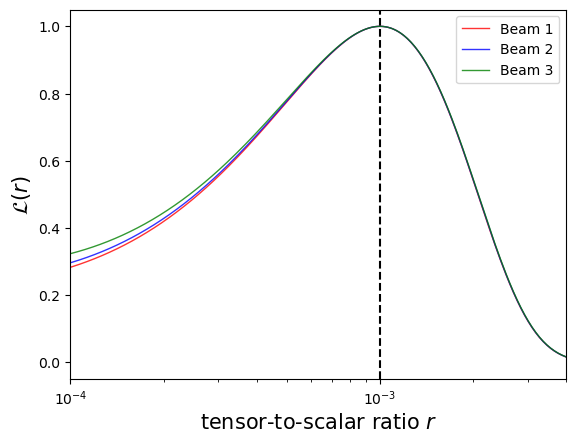

In [25]:
colors = ["red","blue","green"]

for i in range (num_beam): 
    plt.semilogx( r_grid[i], logL[i], color=colors[i], linestyle='-', linewidth = 1, alpha=0.8, label=f'Beam {i+1}' )
    
plt.axvline(x=0.001, color='k', linestyle='--')
    
plt.ylabel(r'$\mathcal{L}(r)$', fontsize=15)
plt.xlabel(r'tensor-to-scalar ratio $r$', fontsize=15)
plt.xlim(1e-4, 4e-3)
plt.legend()
plt.show()
